In [1]:
import pickle
import numpy as np
import tensorflow as tf
from preppy import Preppy
from seq2seq import Seq2SeqModel
from tensorflow.contrib.seq2seq import *
from tensorflow.python.layers.core import Dense

np.set_printoptions(threshold=np.nan)

In [2]:
params = {
    'embedding_size': 50, # 词的embedding size
    'vocab_size': 0,   # 词汇表大小，读取词汇表获取
    'hidden_size': 64,   # lstm 隐藏层，final hidden state
    'n_layers': 1,  # lstm 层数
    
    'epochs': 1,
    'batch_size': 32,
    
    'grad_clip': 5.0,
    'learning_rate': 0.001,
    
    'save_path' : './Model/Seq2seq/model.ckpt'
}


Make a dataset by reading the train 

In [3]:
def expand(x):
    x['length'] = tf.expand_dims(tf.convert_to_tensor(x['length']),0)
    return x

def deflate(x):
    x['length'] = tf.squeeze(x['length'])
    return x

def tokenizer(sentence):
    return sentence.split()

def save_params(params, path='./Model/Seq2seq/params.pkl'):
    with open(path, 'wb') as out_file:
        pickle.dump(params, out_file)

def load_params(path='./Model/Seq2seq/params.pkl'):
    with open(path, 'rb') as in_file:
        return pickle.load(in_file)

## Read and parse tf record

In [4]:
preppy = pickle.load(open('./data/seq2seq/preppy.pkl','rb'))
params["vocab_size"] = len(preppy.vocab)
tf.reset_default_graph()
dataset_train = tf.data.TFRecordDataset(['./data/seq2seq/train.tfrecord']).map(preppy.parse)
dataset_val = tf.data.TFRecordDataset(['./data/seq2seq/val.tfrecord']).map(preppy.parse)

In [5]:
dataset_train.output_shapes

{'sentence': TensorShape([Dimension(None)])}

In [6]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

## Pad sequences with batch

In [7]:
batched_train = dataset_train.padded_batch(32,padded_shapes={
    "sentence":tf.TensorShape([None])
}, drop_remainder=True)

batched_val = dataset_val.padded_batch(32,padded_shapes={
    "sentence":tf.TensorShape([None])
}, drop_remainder=True)

handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, batched_train.output_types, batched_train.output_shapes)

next_item = iterator.get_next()

In [8]:
batched_train.output_shapes

{'sentence': TensorShape([Dimension(32), Dimension(None)])}

In [9]:
iterator_train = batched_train.make_initializable_iterator()
iterator_val = batched_val.make_initializable_iterator()

handle_train = sess.run(iterator_train.string_handle())
handle_val = sess.run(iterator_val.string_handle())

In [10]:
M = Seq2SeqModel(params)
sess.run(tf.global_variables_initializer())

In [11]:
saver = tf.train.Saver()
saver.restore(sess, params["save_path"])

In [12]:
loss_train = []
loss_val = []

for epoch in range(params["epochs"]):
    print("Epoch: %d"%(epoch))
    sess.run(iterator_train.initializer)
    print("Training")
    while True:
        try:
            sentence = sess.run(next_item,feed_dict={handle: handle_train})
            logits, _, loss = sess.run([M.logits, M.train_op, M.loss],feed_dict={
                M.lr: params["learning_rate"],
                M.sentence : sentence["sentence"]
            })
            loss_train.append(loss)
            print(loss)
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break
    
    print("Validation")
    sess.run(iterator_val.initializer)
    while True:
        try:
            sentence = sess.run(next_item,feed_dict={handle: handle_val})
            loss = sess.run([M.loss], feed_dict={
                M.sentence : sentence["sentence"]
            })
            loss_val.append(loss)
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break

print("Training and Validation Finish")

# Save Model
saver = tf.train.Saver()
saver.save(sess, params["save_path"])
save_params(params)

print('Model Trained and Saved')

Epoch: 0
Training
8.6527405
8.651047
8.648855
8.646721
8.643979
8.642848
8.639293
8.636284
8.632689
8.6295
8.625023
8.61899
8.620624
8.606112
8.597105
8.572386
8.54331
8.521591
8.462693
8.400234
8.373184
8.284909
8.240317
8.136284
8.072831
7.96163
7.863019
7.820665
7.731457
7.6543016
7.5643396
7.5080833
7.453493
7.302027
7.30714
7.2394547
7.0865397
7.103751
7.107382
6.9103208
6.8905597
6.7481794
6.7698827
6.576152
6.670772
6.5779715
6.631096
6.5998163
6.3549266
6.512864
6.588205
6.3390183
6.364741
6.138196
6.5652385
6.321941
6.485783
6.251157
6.1870036
6.2825923
6.3593435
6.447674
6.407743
6.1752567
6.427432
6.340183
6.1599183
6.2632627
6.1095757
6.2436337
6.0588107
6.2722764
5.932068
6.6450295
5.9602003
6.36636
6.2469397
6.1844263
6.3292966
6.1049213
6.5520988
5.982187
6.3298736
5.8136563
6.318685
6.0166807
6.2107615
6.234241
6.1108284
6.294701
6.1549826
6.1354184
6.148198
6.451134
6.1456356
6.0854053
6.2088656
6.0078526
6.1784673
6.0805306
6.1541533
6.2996907
6.1233535
6.2372284
6.24

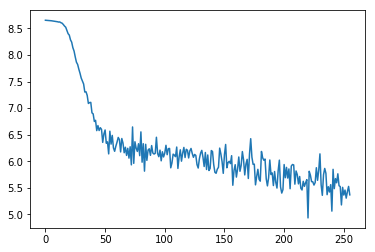

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.show()

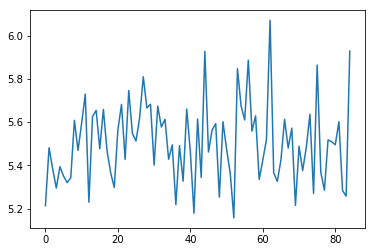

In [16]:
import matplotlib.pyplot as plt
plt.plot(loss_val)
plt.show()